In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
omtf_input = False

tile = 6

In [3]:
# from nn_data.py

import numpy as np

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nn_logging import getLogger
logger = getLogger()

from nn_encode import Encoder


# ______________________________________________________________________________
def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  if correct_for_eta:
    x, y, w, x_mask, x_road = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  else:
    x, y, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, w, x_mask, x_road


def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, w, x_mask, x_road, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test


# ______________________________________________________________________________
def pileup_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0):
  try:
    logger.info('Loading pileup data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = np.zeros((the_variables.shape[0], 1), dtype=np.float32)
    the_aux = loaded['aux']
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the auxiliary PU info with shape {0}'.format(the_aux.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_aux.shape[0])
  assert(the_aux.shape[1] == 4)  # jobid, ievt, highest_part_pt, highest_track_pt

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  x, y, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded auxiliary PU info with shape {0}'.format(the_aux.shape))
  assert(np.isfinite(x).all())
  return x, the_aux, w, x_mask, x_road


def pileup_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_job=50):
  x, aux, w, x_mask, x_road = pileup_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)

  # Split dataset in training and testing
  split = aux[:,0].astype(np.int32) < test_job
  x_train, x_test, aux_train, aux_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = x[split], x[~split], aux[split], aux[~split], w[split], w[~split], x_mask[split], x_mask[~split], x_road[split], x_road[~split]
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))
  return x_train, x_test, aux_train, aux_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test


# ______________________________________________________________________________
def mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=14., tile=15):

  # Apply veto on PU events with a muon with pT > 14 GeV
  pu_x_train_tmp = ~(pu_aux_train[:,2] > discr_pt_cut)
  pu_x_train = pu_x_train[pu_x_train_tmp]
  pu_y_train = [pu_y_train[0][pu_x_train_tmp], pu_y_train[1][pu_x_train_tmp]]

  # Put together x_train & pu_x_train, y_train & pu_y_train
  assert(len(pu_y_train) == 2)
  assert(pu_x_train.shape[0] == pu_y_train[0].shape[0])
  assert(pu_x_train.shape[0] == pu_y_train[1].shape[0])
  num_samples = pu_x_train.shape[0]
  index_array = np.arange(num_samples)
  index_array_ext = np.tile(index_array, tile)  # choose tile to make sure pu_x_train_ext has more entries than x_train
  pu_x_train_ext = pu_x_train[index_array_ext]
  pu_y_train_ext = [pu_y_train[0][index_array_ext], pu_y_train[1][index_array_ext]]

  assert(len(y_train) == 2)
  assert(x_train.shape[0] == y_train[0].shape[0])
  assert(x_train.shape[0] == y_train[1].shape[0])
  if not (pu_x_train_ext.shape[0] >= x_train.shape[0]):
    raise Exception('pu_x_train_ext is required to have more entries than x_train. Make sure {0} >= {1}'.format(pu_x_train_ext.shape[0], x_train.shape[0]))
  num_samples = x_train.shape[0]
  index_array = np.arange(num_samples)
  #np.random.shuffle(index_array)

  try:
    from keras.engine.training import _make_batches as make_batches
  except ImportError:
    from keras.engine.training_utils import make_batches

  sample_batch_size = 128
  batches = make_batches(num_samples, sample_batch_size)

  x_train_new = np.zeros((num_samples*2, x_train.shape[1]), dtype=np.float32)
  y_train_new = [np.zeros((num_samples*2,), dtype=np.float32), np.zeros((num_samples*2,), dtype=np.float32)]

  for batch_index, (batch_start, batch_end) in enumerate(batches):
    batch_ids = index_array[batch_start:batch_end]
    x_train_new[batch_start*2:batch_start*2 + (batch_end-batch_start)] = x_train[batch_ids]
    x_train_new[batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_x_train_ext[batch_ids]
    y_train_new[0][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[0][batch_ids]
    y_train_new[0][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[0][batch_ids]
    y_train_new[1][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[1][batch_ids]
    y_train_new[1][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[1][batch_ids]

  logger.info('Mixed muon data with pileup data. x_train_new has shape {0}, y_train_new has shape {1},{2}'.format(x_train_new.shape, y_train_new[0].shape, y_train_new[1].shape))
  return x_train_new, y_train_new

In [4]:
# from nn_encode.py

import numpy as np

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

nvariables = 36  # 20 (CSC) + 8 (RPC) + 4 (GEM) + 4 (ME0)

nvariables_input = (nlayers * (10+1)) + 3

nparameters_input = 6


# ______________________________________________________________________________
class Encoder(object):

  def __init__(self, x, y, reg_pt_scale=1.0, reg_dxy_scale=1.0,
               drop_ge11=False, drop_ge21=False, drop_me0=False,
               drop_irpc=False, drop_dt=False):

    if x is None or y is None:
      raise Exception('Invalid input x or y')

    assert(x.shape[1] == nvariables_input)
    if y.shape[1] == 1:
      y = np.zeros((y.shape[0], nparameters_input), dtype=np.float32)
    else:
      assert(y.shape[1] == nparameters_input)
    assert(x.shape[0] == y.shape[0])

    self.nentries = x.shape[0]
    self.x_orig  = x
    self.y_orig  = y
    self.x_copy  = x.copy()
    self.y_copy  = y.copy()

    # ________________________________________________________________________
    # Get views

    # Each layer can have 0 or 1 hit. If there is a hit, each hit has several
    # features (phi, theta, bend, quality, time, etc). Currently there are 10.
    # Each layer also has a 'mask' variable that indicates if there is a hit
    # (0: has hit, 1: no hit).
    # Additionally, each pattern has 3 features (straightness, zone, key_phi)
    # Note that some inputs are not actually used.
    self.x_phi       = self.x_copy[:, nlayers*0:nlayers*1]
    self.x_theta     = self.x_copy[:, nlayers*1:nlayers*2]
    self.x_bend      = self.x_copy[:, nlayers*2:nlayers*3]
    self.x_qual      = self.x_copy[:, nlayers*3:nlayers*4]
    self.x_time      = self.x_copy[:, nlayers*4:nlayers*5]
    self.x_ring      = self.x_copy[:, nlayers*5:nlayers*6]
    self.x_fr        = self.x_copy[:, nlayers*6:nlayers*7]
    self.x_old_phi   = self.x_copy[:, nlayers*7:nlayers*8]
    self.x_old_bend  = self.x_copy[:, nlayers*8:nlayers*9]
    self.x_ext_theta = self.x_copy[:, nlayers*9:nlayers*10]
    self.x_mask      = self.x_copy[:, nlayers*10:nlayers*11].astype(np.bool)  # this makes a copy
    self.x_road      = self.x_copy[:, nlayers*11:nlayers*12]  # ipt, ieta, iphi
    self.y_pt        = self.y_copy[:, 0]  # q/pT
    self.y_phi       = self.y_copy[:, 1]
    self.y_eta       = self.y_copy[:, 2]
    self.y_vx        = self.y_copy[:, 3]
    self.y_vy        = self.y_copy[:, 4]
    self.y_vz        = self.y_copy[:, 5]

    # Scale q/pT for training
    self.y_pt  *= reg_pt_scale

    # Scale dxy for training
    #self.y_dxy  = np.sqrt(self.y_vx*self.y_vx + self.y_vy*self.y_vy)
    #self.y_dxy *= np.sign(np.cos(np.arctan2(self.y_vy, self.y_vx) - self.y_phi))
    self.y_dxy  = self.y_vy * np.cos(self.y_phi) - self.y_vx * np.sin(self.y_phi)
    self.y_dxy *= reg_dxy_scale

    # ________________________________________________________________________
    # Drop detectors
    x_dropit = self.x_mask.copy()
    if drop_ge11:
      x_dropit[:, 9] = 1  # 9: GE1/1
    if drop_ge21:
      x_dropit[:, 10] = 1 # 10: GE2/1
    if drop_me0:
      x_dropit[:, 11] = 1 # 11: ME0
    if drop_irpc:
      x_ring_tmp = self.x_ring.astype(np.int32)
      x_ring_tmp = (x_ring_tmp == 2) | (x_ring_tmp == 3)
      x_dropit[~x_ring_tmp[:,7], 7] = 1  # 7: RE3, neither ring2 nor ring3
      x_dropit[~x_ring_tmp[:,8], 8] = 1  # 8: RE4, neither ring2 nor ring3
    if drop_dt:
      x_dropit[:, 12:16] = 1 # 12,13,14,15: MB1,2,3,4

    self.x_phi      [x_dropit] = np.nan
    self.x_theta    [x_dropit] = np.nan
    self.x_bend     [x_dropit] = np.nan
    self.x_qual     [x_dropit] = np.nan
    self.x_time     [x_dropit] = np.nan
    self.x_ring     [x_dropit] = np.nan
    self.x_fr       [x_dropit] = np.nan
    self.x_old_phi  [x_dropit] = np.nan
    self.x_old_bend [x_dropit] = np.nan
    self.x_ext_theta[x_dropit] = np.nan
    self.x_mask     [x_dropit] = 1

    # ________________________________________________________________________
    # Straightness & zone
    self.x_straightness  = self.x_road[:, 0][:, np.newaxis]
    self.x_zone          = self.x_road[:, 1][:, np.newaxis]

    # Subtract median phi from hit phis
    self.x_phi_median    = self.x_road[:, 2] * 32  # multiply by 'quadstrip' unit (4 * 8)
    self.x_phi_median    = self.x_phi_median[:, np.newaxis]
    self.x_phi          -= self.x_phi_median
    self.x_phi          /= 32

    self.x_old_phi      -= self.x_phi_median
    self.x_old_phi      /= 32

    # Subtract median theta from hit thetas
    self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
    self.x_theta_median  = self.x_theta_median[:, np.newaxis]
    self.x_theta        -= self.x_theta_median  #FIXME
    self.x_theta        /= 8

    # Rescale ME0 & DT bending angles
    self.x_bend[:, 11:12] /= 4
    self.x_bend[:, 12:16] /= 32

    # Modify ring and F/R definitions
    x_ring_tmp = self.x_ring.astype(np.int32)
    self.x_ring[(x_ring_tmp == 2) | (x_ring_tmp == 3)] = +1 # ring 2,3 -> +1
    self.x_ring[(x_ring_tmp == 1) | (x_ring_tmp == 4)] = -1 # ring 1,4 -> -1
    x_fr_tmp = self.x_fr.astype(np.int32)
    self.x_fr[(x_fr_tmp == 1)] = +1  # front chamber -> +1
    self.x_fr[(x_fr_tmp == 0)] = -1  # rear chamber  -> -1

    # ________________________________________________________________________
    # Zero out certain variables
    self.x_bend    [:, 5:11] = 0 # no bend for RPC, GEM
    self.x_old_bend[:, 5:11] = 0 # ^
    self.x_qual    [:, 5:11] = 0 # no qual for RPC, GEM
    self.x_time    [:, 0:16] = 0 # no time for everyone

    # Add dedicated GEM-CSC bend
    # Need to account for ME1/1 f or r
    #self.x_gem_csc_bend = (self.x_orig[:,9] - self.x_orig[:,0])         # 9: GE1/1, 0: ME1/1
    #self.x_gem_csc_bend[(self.x_mask[:,9] | self.x_mask[:,0])] = np.nan # 9: GE1/1, 0: ME1/1
    #self.x_gem_csc_bend = np.hstack((self.x_gem_csc_bend[:,np.newaxis], self.x_gem_csc_bend[:,np.newaxis]))
    #self.x_gem_csc_bend[(self.x_fr[:,0]!=0),0] = np.nan  # for ME1/1r bend, set ME1/1f to nan
    #self.x_gem_csc_bend[(self.x_fr[:,0]!=1),1] = np.nan  # for ME1/1f bend, set ME1/1r to nan

    # ________________________________________________________________________
    # Remove NaN
    self._handle_nan_in_x(self.x_copy)
    #self._handle_nan_in_x(self.x_gem_csc_bend)
    return

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def _handle_nan_in_x(self, x):
    x[np.isnan(x)] = 0.0
    return x

  def get_x(self, drop_columns_of_zeroes=True, drop_columns_emtf=True, drop_columns_omtf=False):
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_qual, self.x_time))

    # Drop input nodes
    if drop_columns_of_zeroes:
      drop_phi    = [nlayers*0 + x for x in xrange(0,0)]   # keep everyone
      drop_theta  = [nlayers*1 + x for x in xrange(0,0)]   # keep everyone
      drop_bend   = [nlayers*2 + x for x in xrange(5,11)]  # no bend for RPC, GEM
      drop_qual   = [nlayers*3 + x for x in xrange(5,11)]  # no qual for RPC, GEM
      drop_time   = [nlayers*4 + x for x in xrange(0,16)]  # no time for everyone

      x_dropit = np.zeros(x_new.shape[1], dtype=np.bool)
      for i in drop_phi + drop_theta + drop_bend + drop_qual + drop_time:
        x_dropit[i] = True
      x_new = x_new[:, ~x_dropit]

    # Drop more input nodes (in EMTF mode)
    if drop_columns_emtf:
      drop_phi    = [nlayers*0 + x for x in [12,13,14,15]]  # drop MB1, MB2, MB3, MB4
      drop_theta  = [nlayers*1 + x for x in [12,13,14,15]]  # drop MB1, MB2, MB3, MB4
      drop_bend   = [nlayers*2 + x for x in [6,7,8,9]]      # drop MB1, MB2, MB3, MB4
      drop_qual   = [nlayers*2 + x for x in [16,17,18,19]]  # drop MB1, MB2, MB3, MB4
      drop_time   = [nlayers*2 + x for x in []]             # drop nothing
      #
      x_dropit = np.zeros(x_new.shape[1], dtype=np.bool)
      for i in drop_phi + drop_theta + drop_bend + drop_qual + drop_time:
        x_dropit[i] = True
      x_new = x_new[:, ~x_dropit]

    # Drop more input nodes (in OMTF mode)
    if drop_columns_omtf:
      drop_phi    = [nlayers*0 + x for x in [0,4,8,9,10,11,15]] # drop ME1/1, ME4, RE4, GE1/1, GE2/1, ME0, MB4
      drop_theta  = [nlayers*1 + x for x in [0,4,8,9,10,11,15]] # drop ME1/1, ME4, RE4, GE1/1, GE2/1, ME0, MB4
      drop_bend   = [nlayers*2 + x for x in [0,4,5,9]]          # drop ME1/1, ME4, ME0, MB4
      drop_qual   = [nlayers*2 + x for x in [10,14,15,19]]      # drop ME1/1, ME4, ME0, MB4
      drop_time   = [nlayers*2 + x for x in []]                 # drop nothing
      #
      x_dropit = np.zeros(x_new.shape[1], dtype=np.bool)
      for i in drop_phi + drop_theta + drop_bend + drop_qual + drop_time:
        x_dropit[i] = True
      x_new = x_new[:, ~x_dropit]
      #
      x_rsvd = np.zeros((x_new.shape[0],6), dtype=np.float32)
      x_new = np.hstack((x_new, x_rsvd))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_road(self):
    x_road = np.hstack((self.x_straightness, self.x_zone, self.x_theta_median))
    return x_road

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_y_corrected_for_eta(self):
    y_new = self.y_pt * (np.sinh(1.8587) / np.sinh(np.abs(self.y_eta)))
    return y_new

  def get_dxy(self):
    dxy_new = self.y_dxy.copy()
    return dxy_new

  def get_dz(self):
    dz_new = self.y_vz.copy()
    return dz_new

  def get_w(self):
    w_new = np.ones_like(self.y_pt)
    return w_new

### Import data

In [5]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
if not omtf_input:
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon, reg_pt_scale=reg_pt_scale, test_size=0.31)
else:
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_omtf, reg_pt_scale=reg_pt_scale, test_size=0.317)
  
# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.24.npz ...
[INFO    ] Loaded the variables with shape (3305518, 179)
[INFO    ] Loaded the parameters with shape (3305518, 6)
[INFO    ] Loaded the encoded variables with shape (3305518, 36)
[INFO    ] Loaded the encoded parameters with shape (3305518,)
[INFO    ] Loaded # of training and testing events: (2280807, 1024711)


In [6]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)
if not omtf_input:
  pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
      pileup_data_split(infile_pileup, reg_pt_scale=reg_pt_scale, test_job=159)
else:
  pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
      pileup_data_split(infile_pileup_omtf, reg_pt_scale=reg_pt_scale, test_job=159)

# Add output nodes for pileup data
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]

[INFO    ] Loading pileup data from ../test7/histos_tbd.24.npz ...
[INFO    ] Loaded the variables with shape (486432, 179)
[INFO    ] Loaded the auxiliary PU info with shape (486432, 4)
[INFO    ] Loaded the encoded variables with shape (486432, 36)
[INFO    ] Loaded the encoded auxiliary PU info with shape (486432, 4)
[INFO    ] Loaded # of training and testing events: (398946, 87486)


In [7]:
# Mix muon & pileup data
x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=tile)

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4561614, 36), y_train_new has shape (4561614,),(4561614,)


### Make plots

In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

0 (647938,) (2280807,) (4561614,)
1 (647938,) (2280807,) (4561614,)
2 (647938,) (2280807,) (4561614,)
3 (647938,) (2280807,) (4561614,)
4 (647938,) (2280807,) (4561614,)
5 (647938,) (2280807,) (4561614,)
6 (647938,) (2280807,) (4561614,)
7 (647938,) (2280807,) (4561614,)
8 (647938,) (2280807,) (4561614,)
9 (647938,) (2280807,) (4561614,)
10 (647938,) (2280807,) (4561614,)
11 (647938,) (2280807,) (4561614,)
12 (647938,) (2280807,) (4561614,)
13 (647938,) (2280807,) (4561614,)
14 (647938,) (2280807,) (4561614,)
15 (647938,) (2280807,) (4561614,)
16 (647938,) (2280807,) (4561614,)
17 (647938,) (2280807,) (4561614,)
18 (647938,) (2280807,) (4561614,)
19 (647938,) (2280807,) (4561614,)
20 (647938,) (2280807,) (4561614,)
21 (647938,) (2280807,) (4561614,)
22 (647938,) (2280807,) (4561614,)
23 (647938,) (2280807,) (4561614,)
24 (647938,) (2280807,) (4561614,)
25 (647938,) (2280807,) (4561614,)
26 (647938,) (2280807,) (4561614,)
27 (647938,) (2280807,) (4561614,)
28 (647938,) (2280807,) (45616

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


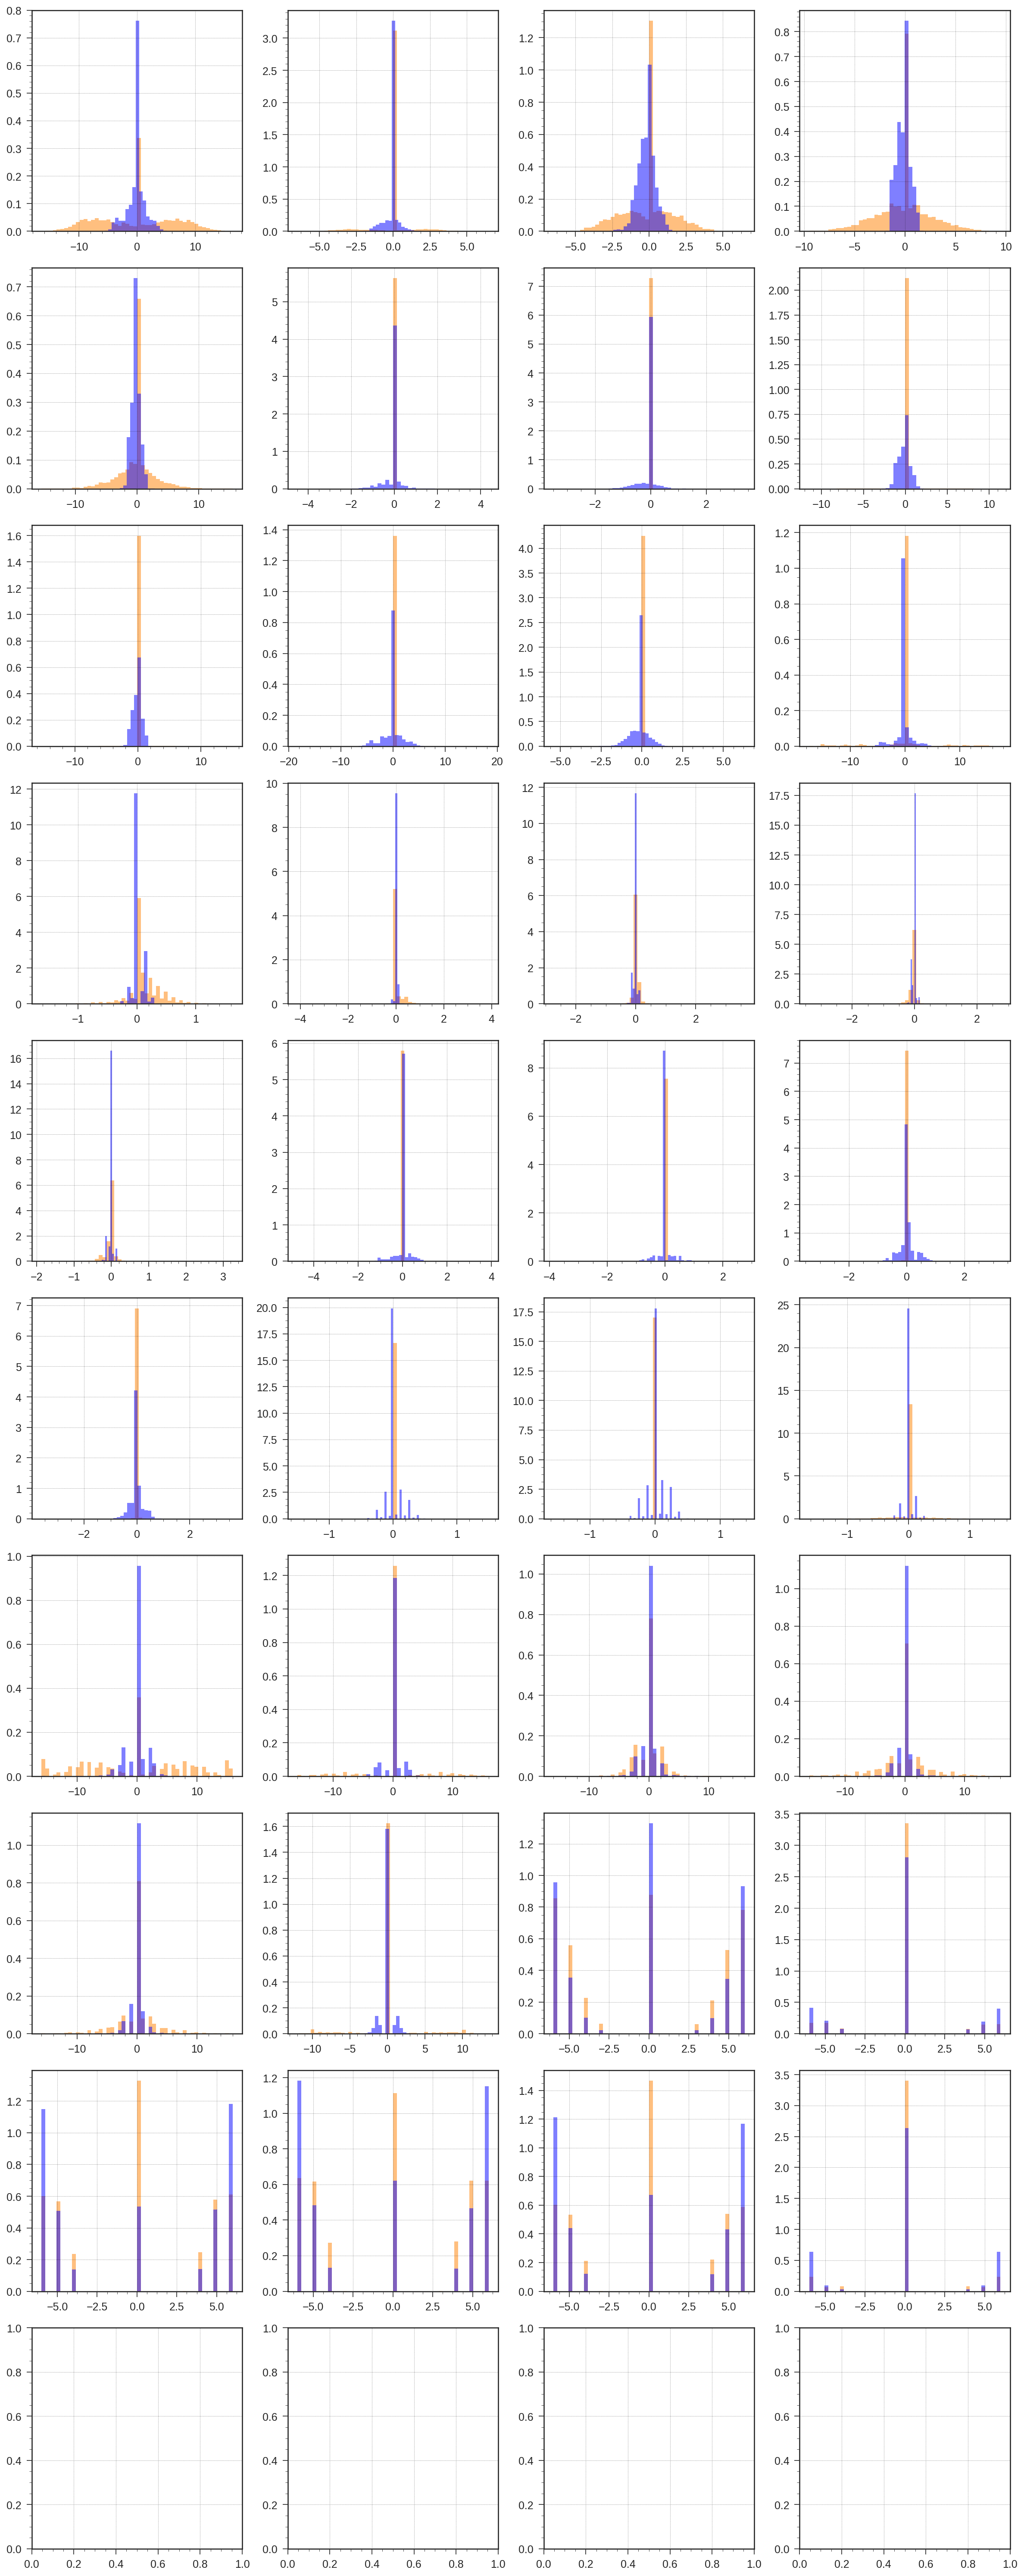

In [9]:
fig, axs = plt.subplots(40/4, 4, figsize=(4*4,4*40/4), tight_layout=True)

_kwargs = dict(histtype='stepfilled', linewidth=2, alpha=0.5, density=True, bins=50)

for i in xrange(x_train.shape[1]):
  x_sig = x_train_new[:, i].copy()
  x_bkg = x_train_new[:, i].copy()
  y_discr = y_train_new[1].copy()
  
  #print i, x_sig.shape, x_bkg.shape, y_discr.shape
  
  x_sig = x_sig[y_discr == 1]
  x_bkg = x_bkg[y_discr == 0]
  
  print i, x_sig.shape, x_bkg.shape, y_discr.shape
  
  # Background in orange
  hist = axs[(i/4, i%4)].hist(x_bkg, color='#FF8000', **_kwargs)
  
  # Signal in blue
  hist = axs[(i/4, i%4)].hist(x_sig, color='blue', **_kwargs)
  
  ##FIXME
  #hist = axs[(i/4, i%4)].hist(x_bkg[x_bkg != 0], color='#FF8000', **_kwargs)

0 (441230,) (314889,) (2280807,) (398946,)
1 (210797,) (77892,) (2280807,) (398946,)
2 (564910,) (271658,) (2280807,) (398946,)
3 (551276,) (292295,) (2280807,) (398946,)
4 (543588,) (258367,) (2280807,) (398946,)
5 (157696,) (352,) (2280807,) (398946,)
6 (152350,) (65,) (2280807,) (398946,)
7 (546632,) (15255,) (2280807,) (398946,)
8 (517060,) (12314,) (2280807,) (398946,)
9 (291760,) (377,) (2280807,) (398946,)
10 (354100,) (368,) (2280807,) (398946,)
11 (237693,) (73430,) (2280807,) (398946,)
12 (441230,) (314889,) (2280807,) (398946,)
13 (210797,) (77892,) (2280807,) (398946,)
14 (564910,) (271658,) (2280807,) (398946,)
15 (551276,) (292295,) (2280807,) (398946,)
16 (543588,) (258367,) (2280807,) (398946,)
17 (157696,) (352,) (2280807,) (398946,)
18 (152350,) (65,) (2280807,) (398946,)
19 (546632,) (15255,) (2280807,) (398946,)
20 (517060,) (12314,) (2280807,) (398946,)
21 (291760,) (377,) (2280807,) (398946,)
22 (354100,) (368,) (2280807,) (398946,)
23 (237693,) (73430,) (2280807,

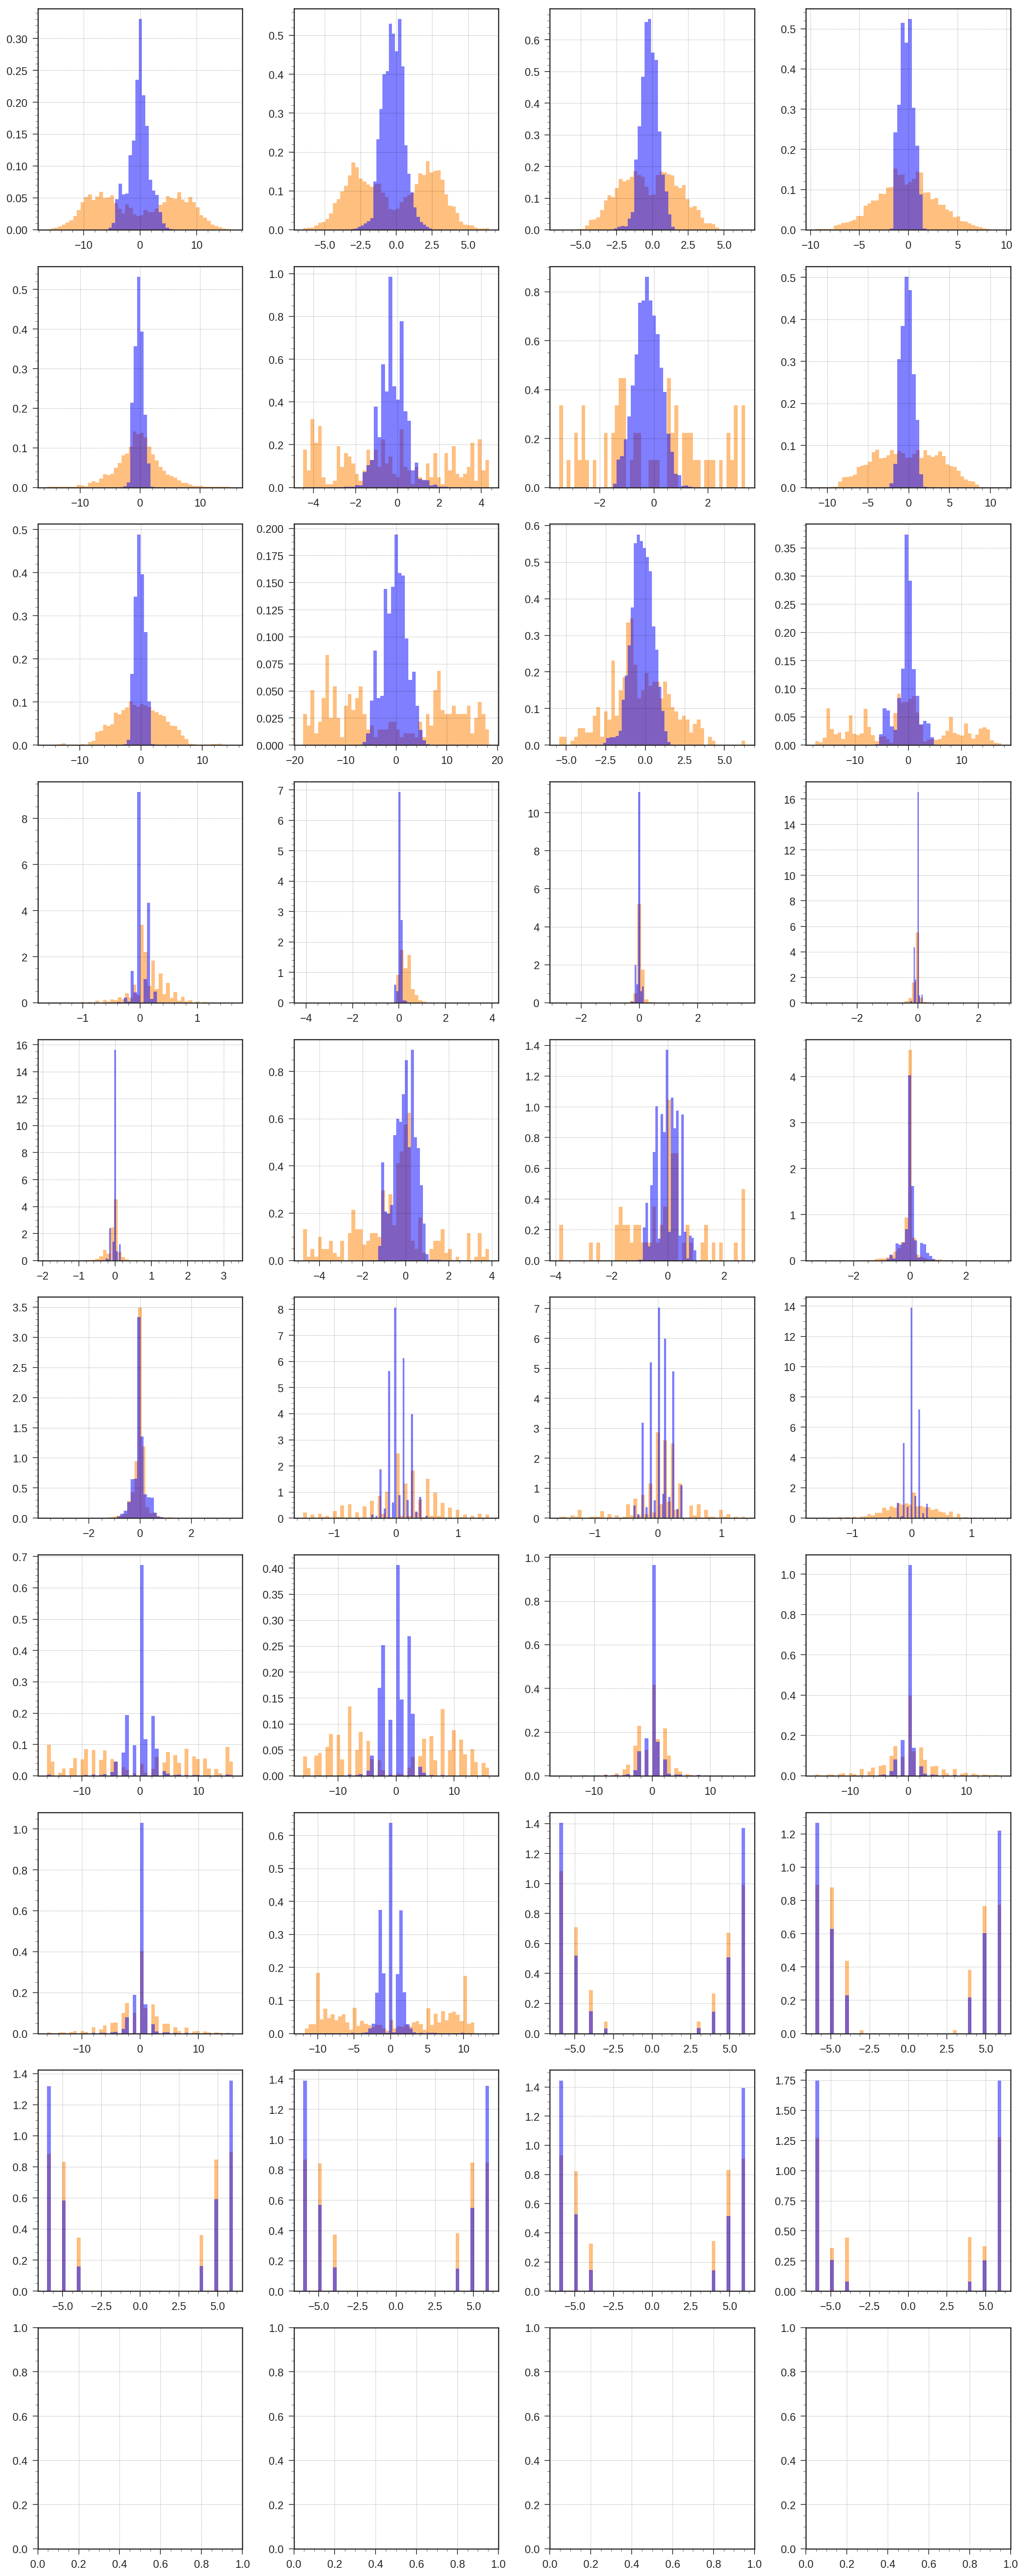

In [10]:
fig, axs = plt.subplots(40/4, 4, figsize=(4*4,4*40/4), tight_layout=True)

_kwargs = dict(histtype='stepfilled', alpha=0.5, linewidth=2, density=True, bins=50)

def parse_x_mask(x_mask):
  nentries = x_mask.shape[0]
  x_mask_new = np.ones((nentries, nvariables), dtype=np.bool)
  x_mask_new[:, 0:12]  = np.hstack((x_mask[:, 0:12],))
  x_mask_new[:, 12:24] = np.hstack((x_mask[:, 0:12],))
  x_mask_new[:, 24:30] = np.hstack((x_mask[:,0:5], x_mask[:,11:12]))
  x_mask_new[:, 30:36] = np.hstack((x_mask[:,0:5], x_mask[:,11:12]))
  return x_mask_new

x_mask_train_new = parse_x_mask(x_mask_train)
pu_x_mask_train_new = parse_x_mask(pu_x_mask_train)

for i in xrange(x_train.shape[1]):
  x_sig = x_train[:, i].copy()
  x_bkg = pu_x_train[:, i].copy()
  y_sig = y_train[1].copy()
  y_bkg = pu_y_train[1].copy()
  x_mask_sig = x_mask_train_new[:, i].copy()
  x_mask_bkg = pu_x_mask_train_new[:, i].copy()
  
  #print i, x_sig.shape, x_bkg.shape, x_mask_sig.shape, x_mask_bkg.shape
  
  x_sig = x_sig[(~x_mask_sig) & (y_sig == 1)]
  x_bkg = x_bkg[(~x_mask_bkg) & (y_bkg == 0)]
  
  print i, x_sig.shape, x_bkg.shape, x_mask_sig.shape, x_mask_bkg.shape
  
  # Background in orange
  hist = axs[(i/4, i%4)].hist(x_bkg, color='#FF8000', **_kwargs)
  
  # Signal in blue
  hist = axs[(i/4, i%4)].hist(x_sig, color='blue', **_kwargs)